In [2]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

from skimage.filters import sobel
from skimage.morphology import label
from scipy.ndimage import gaussian_filter,gaussian_gradient_magnitude, binary_fill_holes
from skimage.morphology import skeletonize,binary_dilation
from scipy.signal import fftconvolve
from skimage.morphology import binary_dilation

from numpy.linalg import lstsq

from scipy.ndimage import gaussian_filter

from scipy.interpolate import RectBivariateSpline

from tqdm import tqdm,trange


In [2]:
# Functions for getting the initial contour

def get_pruned_skeleton(skel):
    #prune skeleton branches
    doughnut = np.ones((3,3))
    doughnut[1,1]=0
    # define interface end points
    # detect connected components where all pixels have two neighbors
    # if a component includes a on-neighbor pixel that is not 
    # a defined end point, remove these pixels from skeleton
    neighbors = np.round(skel*\
                         fftconvolve(skel,doughnut,'same'))\
                .astype(int)
    #define interface endpoints
    one_neighbor = neighbors == 1
    Iend,Jend = np.where(one_neighbor)
    left_end = (Iend[np.argmin(Jend)],np.min(Jend))
    right_end = (Iend[np.argmax(Jend)],np.max(Jend))
    one_neighbor_no_endpoints = np.copy(one_neighbor)
    one_neighbor_no_endpoints[right_end] = 0
    one_neighbor_no_endpoints[left_end] = 0
    Iend,Jend = np.where(one_neighbor_no_endpoints)
    # if a component includes a one-neighbor pixel that is not 
    # a defined end point, remove these pixels from skeleton
    pruned_skel= np.copy(skel)
    two_neighbor = (neighbors>0)*(neighbors<3)
    two_comp = label(two_neighbor)

    for i,j in zip(Iend,Jend):
        pruned_skel[binary_dilation(two_comp == two_comp[i,j])] = 0
    
    return pruned_skel

def reorder_interface_points(xx,yx):
    #reorder skeleton points to produce path
    dist = np.sqrt(np.diff(xx)**2+np.diff(yx)**2)
    #a jump is defined as two points separated by more that two pixels
    jumps = np.where(dist>np.sqrt(2))[0]

    # for each jump, reorder points to minimize distances
    x = np.copy(xx);y = np.copy(yx)

    while any(jumps):
        j = jumps[0]
        distance_from_j = (x[j]-x[j+1:])**2 + (y[j]-y[j+1:])**2
        closest_point_to_j = j+1 + np.argmin(distance_from_j)
        if closest_point_to_j != j+1:
            xjplus1 = x[j+1];yjplus1 = y[j+1]
            x[j+1] = x[closest_point_to_j]
            y[j+1] = y[closest_point_to_j]
            x[closest_point_to_j] = xjplus1
            y[closest_point_to_j] = yjplus1
        dist = np.sqrt(np.diff(x[j+1:])**2+np.diff(y[j+1:])**2)
        #a jump is defined as two points separated by more that two pixels
        jumps = j+1+np.where(dist>np.sqrt(2))[0]
    return x,y
    

def crude_interface_detector(im,bg,thresh):
    #renormalize image with background
    im_renorm = im/bg;
    #2021-12-15 IK: smooth image before thresholding
    im_smooth = gaussian_filter(im_renorm,sigma=1)
    # thresholding
    im_BW = im_smooth>thresh
    #detect above threshold edges with sobel
    #0.7 is a good threshold for skimage sobel filter of a binary image
    edge_map = (sobel(im_BW)>0.7).astype('bool')
    #get the largest component (the interface)
    bwlabels = label(edge_map)
    compsizes = [len(np.where(bwlabels == i)[0])\
                  for i in range(1,np.max(bwlabels)+1)]

    largest_comp = np.argmax(compsizes)+1
    #check that every x value has an interface
    x_isinterface = np.zeros(im.shape[1],dtype = np.bool_)
    #add largest comp to x_isinterface
    x_isinterface =  np.logical_or(x_isinterface,np.sum(bwlabels == largest_comp,axis=0)>0)    
    #look for components for the remaining values
    compcandidates  =[];did_something = True
    while any(np.logical_not(x_isinterface)) and did_something:
        did_something = False
        for x in np.where(np.logical_not(x_isinterface))[0]:
            for y in np.where(bwlabels[:,x])[0]:
                comp = bwlabels[y,x]
                #get the j-range of the  comp
                x_isinterface =  np.logical_or(x_isinterface,np.sum(bwlabels == comp,axis=0)>0)  
                compcandidates.append(comp)  
                did_something = True
    #take the component with most j values
    if any(compcandidates):
        compsizes = [len(np.where(bwlabels == c)[0])\
                  for c in compcandidates]
        second_largest_comp = compcandidates[np.argmax(compsizes)]
        bwinterface = np.logical_or(bwlabels == largest_comp,\
                                    bwlabels == second_largest_comp)
    else:
        bwinterface = bwlabels == largest_comp

    bwinterface = binary_fill_holes(bwinterface)
    #skeletonize interface
    skel_interface = skeletonize(bwinterface)    
   
    #pruned_skel = get_pruned_skeleton(skel_interface)
   
    #get skeleton coordinates
    xx,yx = np.where(np.transpose(skel_interface))
   
    return reorder_interface_points(xx,yx)

In [3]:
# Functions for getting the background

def polyfit2(x,y,z):
    
    N = len(x)
    
    matrix = np.vstack(\
                    [np.ones(N),x,y,x**2,x*y,y**2]\
                        ).T
    
    lstsq_result = lstsq(matrix,z,rcond=None)
    
    p = lstsq_result[0]
    
    return p

def polyval2(p,xstart, xend, ystart, yend):
    
   
    x,y = np.meshgrid(np.arange(ystart, yend), np.arange(xstart, xend))
    
    
    arrfit = p[0]*np.ones((xend-xstart, yend-ystart)) + p[1]*x + p[2]*y +p[3]*x**2 + p[4]*x*y \
    + p[5]*y**2
        
    return arrfit


In [4]:
# Functions for final refinement
# first calculate smooth gradient at each point
#find subpixel threshold by interpolation
def final_refine_IKedit_(im, x, y,thresh, n=2):
    #take gradients of the smooth image
    im_smooth = gaussian_filter(im,sigma=1)
    [Dy,Dx] = np.gradient(im_smooth)

    t = np.linspace(-n,n,5*n) # section parameterization
    #trim interface for slicing images later
    trimmer = np.where(np.logical_and(x>n,x<im_smooth.shape[1]-n))[0]
    xtrim = x[trimmer]
    ytrim = y[trimmer]
    #initialize subpixel arrays
    xs = np.zeros(len(xtrim))
    ys = np.zeros(len(xtrim))

    for xi,yi,i in zip(xtrim,ytrim,range(len(xtrim))):
        Dxi = Dx[yi,xi]; Dyi = Dy[yi,xi]
        magD = np.sqrt(Dxi**2+Dyi**2)
        nx = Dxi/magD; ny = Dyi/magD
        im_slice = im_smooth[yi - n:yi+n,xi-n:xi+n]
        intp = RectBivariateSpline(np.arange(-n,n),
                               np.arange(-n,n),
                               im_slice, kx=2, ky=2, s=0)
        section2 = intp(ny*t,nx*t,grid=False)
        #section = im_smooth[(yi +ny*t).astype(int),(xi +nx*t).astype(int)]
        #ti = np.interp(th,section,t)
        ti = t[np.argmin(np.abs(section2-thresh))]
        xs[i] = xi +nx*ti
        ys[i] = yi + ny*ti

    return xs, ys


In [415]:
datafolder = r'C:\Users\dogic lab\Documents\Ray\2x_1x1_15s_275nM_largeInterface_1\Default';
##folder = '\Pos1'
##folder = '\Pos2'
##folder = '\Pos3'
folder = '\Pos4'
#folder = '\Pos5'

tstart=500
tend=600



imag_names = np.sort(glob(datafolder+folder+'/*'))

print('Number of images: '+str(int(len(imag_names))))


Number of images: 2007


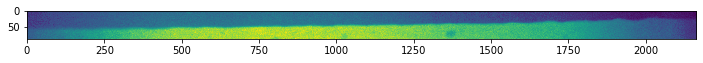

In [416]:
#Find the region directly above the interface

plt.figure(figsize=(12,12))
im = plt.imread(imag_names[tstart])
L1, L2 = np.shape(im)


xmin = 750
xmax = 840

x_l = xmax-xmin

dy1 = 70
dy2 = 70



name = imag_names[tstart]
im1 = plt.imread(name)[xmin:xmax, dy1:-dy2]

plt.imshow(im1)


In [417]:


bck = np.zeros((x_l, L2-dy1-dy2, tend-tstart+1))

for t in range(tstart, tend):
    name = imag_names[t]
    im = plt.imread(name)
    bck[:,:,t-tstart] = im[xmin-x_l:xmin,dy1:-dy2]
    
top_background = np.mean(bck, axis=2)

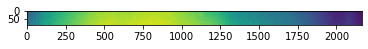

In [418]:
plt.imshow(top_background)

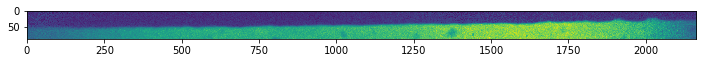

In [419]:
name = imag_names[tend]
im1 = plt.imread(name)[xmin:xmax, dy1:-dy2]

plt.figure(figsize=(12,12))

#background = gaussian_filter(im[xmax:xmax+x_l,dy:-dy], 20)

plt.imshow(im1/top_background)


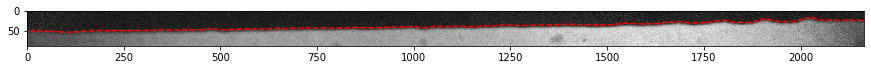

In [429]:

name = imag_names[tstart+40]
im1 = plt.imread(name)[xmin:xmax, dy1:-dy2]

thresh = 1.24

x,y = crude_interface_detector(im1,top_background,thresh)

final_x = np.where(x==np.max(x))[0][-1]

x = x[:final_x]

y = y[:final_x]

xs,ys = final_refine_IKedit_(im1/top_background, x, y, 0.75, n=2)

plt.figure(figsize=(15,15))
plt.imshow(im1/top_background, 'gray')
plt.plot(xs,ys,'r--')


In [430]:
X_f = []
Y_f = []

folder2 = '/Figure'

for t in trange(tstart, tend):

    name = imag_names[t]
    im1 = plt.imread(name)[xmin:xmax, dy1:-dy2]
    
    x,y = crude_interface_detector(im1,top_background,thresh)
    final_x = np.where(x==np.max(x))[0][-1]

    x = x[:final_x]

    y = y[:final_x]
    xs,ys = final_refine_IKedit_(im1/top_background, x, y, 0.75, n=2)
    
    X_f.append(xs)
    Y_f.append(ys)
    im_renorm = im1/top_background
    plt.figure(figsize=(15,15))
    plt.imshow(im_renorm, 'gray')
    plt.plot(x[:final_x], y[:final_x],'-r')
    plt.savefig(datafolder+folder+folder2+'/TP'+str(t)+'.png')
    plt.close()
    
np.save(datafolder+folder+'/X_f_'+str(tstart)+'_'+str(tend)+'.npy', X_f)
np.save(datafolder+folder+'/Y_f_'+str(tstart)+'_'+str(tend)+'.npy', Y_f)





  0%|          | 0/100 [00:00<?, ?it/s]



  1%|          | 1/100 [00:00<00:29,  3.31it/s]



  2%|▏         | 2/100 [00:00<00:29,  3.29it/s]



  3%|▎         | 3/100 [00:00<00:30,  3.13it/s]



  4%|▍         | 4/100 [00:01<00:30,  3.17it/s]



  5%|▌         | 5/100 [00:02<00:55,  1.70it/s]



  6%|▌         | 6/100 [00:02<00:49,  1.88it/s]



  7%|▋         | 7/100 [00:03<01:01,  1.51it/s]



  8%|▊         | 8/100 [00:04<01:12,  1.27it/s]



  9%|▉         | 9/100 [00:05<00:58,  1.56it/s]



 10%|█         | 10/100 [00:05<00:50,  1.80it/s]



 11%|█         | 11/100 [00:06<01:03,  1.41it/s]



 12%|█▏        | 12/100 [00:06<00:51,  1.70it/s]



 13%|█▎        | 13/100 [00:07<00:43,  1.98it/s]



 14%|█▍        | 14/100 [00:08<00:57,  1.49it/s]



 15%|█▌        | 15/100 [00:08<00:49,  1.72it/s]



 16%|█▌        | 16/100 [00:09<01:06,  1.27it/s]



 17%|█▋        | 17/100 [00:10<00:55,  1.49it/s]



 18%|█▊        | 18/100 [00:10<00:46,  1.77it/s]



 19%|█▉        | 19/100 [0

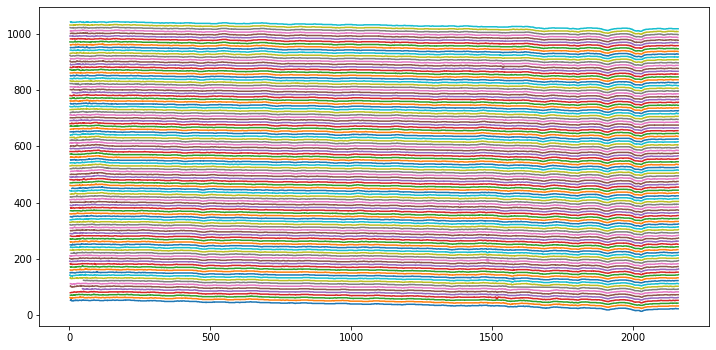

In [431]:
f, ax = plt.subplots(1,1,figsize = (12,100))
for i in range(0,len(X_f),int(len(X_f)/len(X_f))):
    ax.plot(X_f[i],10*i+Y_f[i])
ax.set_aspect('equal')

#ax.set_xlim(0,250);ax.set_ylim(0,250)
        

